[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


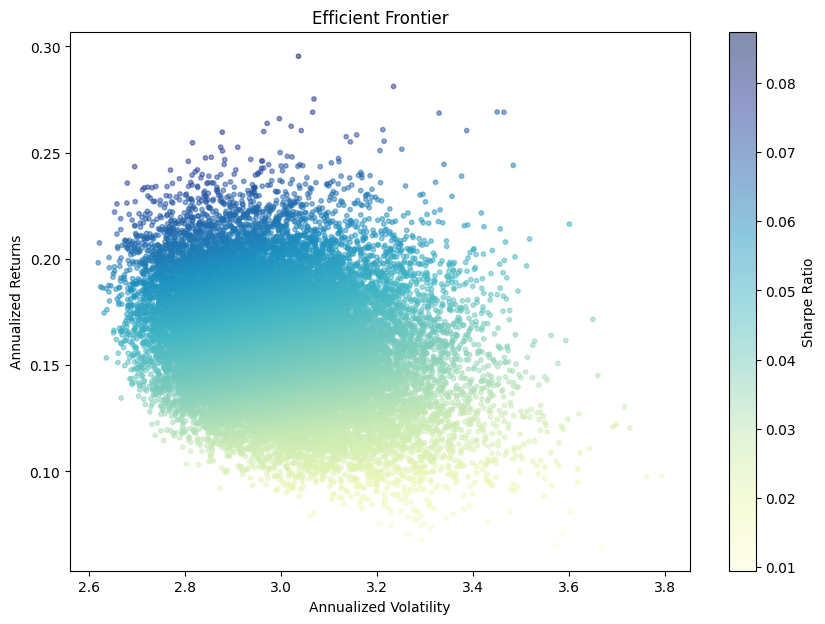

Stock Betas: {'BAJFINANCE.NS': 0.7934448152412309, 'HDFCBANK.NS': 1.0269162394504086, 'ICICIBANK.NS': 1.5205515417207436, 'INFY.NS': 0.712614647102444, 'ITC.NS': 0.6520167333811561, 'KOTAKBANK.NS': 1.138840286370417, 'LT.NS': 1.3509114983172485, 'RELIANCE.NS': 1.1265692259823425, 'SBIN.NS': 1.3083922533968098, 'TCS.NS': 0.6516838571344454}
Expected Returns: {'BAJFINANCE.NS': 0.09347558521929847, 'HDFCBANK.NS': 0.11215329915603268, 'ICICIBANK.NS': 0.15164412333765948, 'INFY.NS': 0.08700917176819553, 'ITC.NS': 0.0821613386704925, 'KOTAKBANK.NS': 0.12110722290963336, 'LT.NS': 0.1380729198653799, 'RELIANCE.NS': 0.1201255380785874, 'SBIN.NS': 0.1346713802717448, 'TCS.NS': 0.08213470857075564}
Portfolio Beta: 0.9872660768136567
Portfolio Expected Return: 0.10898128614509255
Optimal Weights: [0.         0.         0.49235694 0.         0.         0.
 0.21000592 0.         0.29763714 0.        ]
Expected Annual Return: 0.14374237157379163
Annual Volatility/Risk: 0.2834149332790779
Sharpe Ratio

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from scipy.optimize import minimize

# Define the stocks
stocks = ['RELIANCE.NS', 'INFY.NS', 'HDFCBANK.NS', 'KOTAKBANK.NS', 'TCS.NS',
          'BAJFINANCE.NS', 'SBIN.NS', 'ITC.NS', 'LT.NS', 'ICICIBANK.NS']

# Define the time period for historical data
end_date = '2016-01-01'
start_date = '2011-01-01'

# Fetch historical data
data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
nifty_data = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()
nifty_returns = nifty_data.pct_change().dropna()

# Align returns
aligned_returns = returns.join(nifty_returns.rename('NIFTY'), how='inner').dropna()
X = sm.add_constant(aligned_returns['NIFTY'])
aligned_returns.pop('NIFTY')

# Fetch market capitalization for each stock
market_caps = {stock: yf.Ticker(stock).info['marketCap'] for stock in stocks}

# Calculate total market capitalization and weights
total_market_cap = sum(market_caps.values())
weights = np.array([market_caps[stock] / total_market_cap for stock in stocks])

# Calculate Beta values
betas = {}
for stock in aligned_returns.columns:
    y = aligned_returns[stock]
    model = sm.OLS(y, X).fit()
    betas[stock] = model.params[1]

# Risk-free rate and market risk premium (placeholders, update as needed)
risk_free_rate = 0.03
market_risk_premium = 0.08

# Calculate expected returns using CAPM
expected_returns = {stock: risk_free_rate + betas[stock] * market_risk_premium for stock in betas}

# Calculate portfolio Beta
portfolio_beta = sum(betas[stock] * weight for stock, weight in zip(betas, weights))

# Calculate portfolio expected return
portfolio_expected_return = risk_free_rate + portfolio_beta * market_risk_premium

# Portfolio optimization for maximum Sharpe Ratio
mean_returns = aligned_returns.mean()
cov_matrix = aligned_returns.cov() * 252

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    p_ret = np.dot(weights, mean_returns)
    return -(p_ret - risk_free_rate) / np.sqrt(p_var)

constraints = ({'type': 'eq', 'fun': (lambda x: (np.sum(x) - 1))})
bounds = tuple((0, 1) for _ in range(len(stocks)))
initial_guess = 10 * [1. / 10]

opt_results = minimize(neg_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints, tol = 10**(-3))

optimal_weights = opt_results.x

# Calculate the expected return, volatility, and Sharpe Ratio of the optimal portfolio

portfolio_beta_new = sum(betas[stock] * weight for stock, weight in zip(betas, optimal_weights))
opt_ret = risk_free_rate + portfolio_beta_new * market_risk_premium
opt_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
opt_sharpe_ratio = (opt_ret - risk_free_rate) / opt_vol

# Generating portfolios for the efficient frontier
def generate_portfolios(num_portfolios=25000):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        portfolio_std_dev, portfolio_return, _ = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # Sharpe Ratio
    return results

def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights) * 252  # Annualize returns
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualize std. dev.
    sharpe_ratio = (returns - risk_free_rate) / std_dev
    return std_dev, returns, sharpe_ratio

results = generate_portfolios()

# Plotting the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[0], results[1], c=results[2], cmap='YlGnBu', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.show()

print("Stock Betas:", betas)
print("Expected Returns:", expected_returns)
print("Portfolio Beta:", portfolio_beta)
print("Portfolio Expected Return:", portfolio_expected_return)
print(f"Optimal Weights: {optimal_weights}")
print(f"Expected Annual Return: {opt_ret}")
print(f"Annual Volatility/Risk: {opt_vol}")
print(f"Sharpe Ratio: {opt_sharpe_ratio}")
